In [1]:
import os 

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(os.path.join(os.path.abspath(''), 'plot_style.mplstyle'))
plots_dir = '../plots/'

from desilike.samples import Profiles, Chain, plotting

from emulator_fit import get_power_likelihood, get_corr_likelihood

tracer = 'ELG'
region = 'SGC'
stat = 'power'
rp_cut = 2.5

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
emulator_dir = '/global/cfs/cdirs/desi/users/mpinon/emulators/emulators_shapefit_{}'.format(tracer)
profiles_dir = '/global/cfs/cdirs/desi/users/mpinon/profiles/profiles_shapefit_{}_{{}}{}'.format(tracer, region)
chains_dir = '/global/cfs/cdirs/desi/users/mpinon/chains/chains_shapefit_{}_{{}}{}'.format(tracer, region)

## Bias and dispersion of best fit parameters over the 25 mocks

In [3]:
nmocks = 25

In [4]:
chain_rp_cut = Chain.concatenate([Chain.load(os.path.join(chains_dir.format(''), '{}_velocileptors{}_th{:.1f}_{:d}.npy'.format(stat, '_fc' if stat=='corr' else '', rp_cut, i))).remove_burnin(0.5)[::10] for i in range(8)])

In [5]:
chains = [Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), '{}{}_velocileptors_{:d}_marginalized_astar_rpcutwmatrix_mock{}.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', ichain, imock))).remove_burnin(0.5)[::10] for ichain in range(8)]) for imock in range(nmocks)]
chains_rp_cut =  [Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), '{}{}_velocileptors{}_th{:.1f}_{}_marginalized_astar_mock{}.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', '_fc' if stat=='corr' else '', rp_cut, ichain, imock))) .remove_burnin(0.5)[::10] for ichain in range(8)]) for imock in range(nmocks)]
#chains_rp_cut =  [Chain.load(os.path.join(chains_dir.format('complete_'), '{}_mock{}_importance_xinmax0.35_velocileptors{}_marginalized_astar.npy'.format(stat, imock, '_th{:.1f}'.format(rp_cut) if rp_cut else ''))) for imock in range(nmocks)]

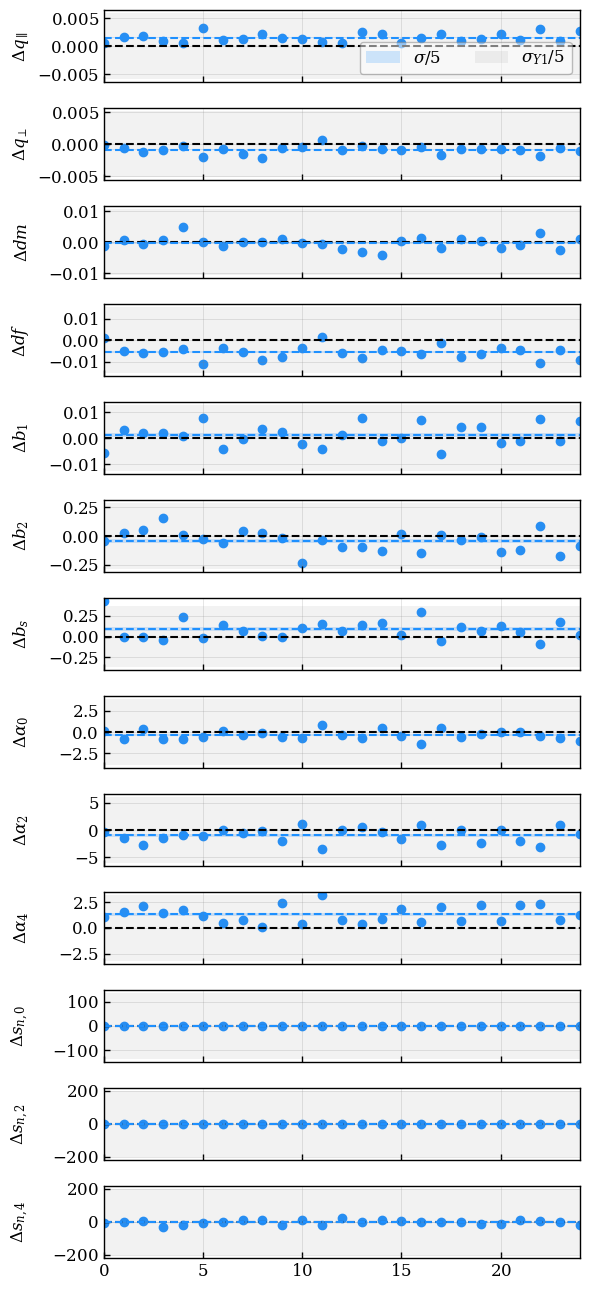

In [6]:
params = ['qpar', 'qper', 'dm', 'df', 'b1', 'b2', 'bs', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'sn4']
nrows = len(params)
figsize = (6, nrows)
fig, lax = plt.subplots(nrows, 1, figsize=figsize, sharex=True)

diff_std_list = []
desi_y1_err_list = []

for iparam, param in enumerate(params):
    bestfit_vals = np.array([chain.mean(param) for chain in chains])
    bestfit_vals_rp_cut = np.array([chain.mean(param) for chain in chains_rp_cut])
    bestfit_diff = bestfit_vals_rp_cut - bestfit_vals
    #print(bestfit_diff)
    diff_mean = np.mean(bestfit_diff)
    diff_std = np.std(bestfit_diff) / 5.
    #print(diff_mean)
    #print(diff_std)
    diff_std_list.append(diff_std)
    x = np.arange(len(bestfit_diff))
    ax = lax[iparam]
    ax.axhline(0, ls='--', color='black')
    ax.axhline(diff_mean, ls='--', color='dodgerblue')
    ax.fill_between(x, diff_mean - diff_std, diff_mean + diff_std, facecolor='dodgerblue', alpha=0.2, label=r'$\sigma/5$')
    ax.scatter(x, bestfit_diff)
    ax.set_ylabel(r'$\Delta$'+chains[0].params()[param].latex(inline=True))
    # DESI Y1 error
    desi_y1_err = chain_rp_cut.std(param)
    desi_y1_err_list.append(desi_y1_err[0])
    ax.fill_between(x, -desi_y1_err/5., desi_y1_err/5., facecolor='grey', alpha=0.1, label=r'$\sigma_{Y1}/5$')
    #ax.set_ylim(-desi_y1_err/4., desi_y1_err/4.)
    ax.set_xlim(0, np.max(x))
    
lax[0].legend(ncol=2)
fig = plt.gcf()
fig.align_ylabels()
plt.savefig(os.path.join(plots_dir, 'bestfit_dispersion_25mocks_{}_importance_marginalized.png'.format(stat)), dpi=200)
plt.show()

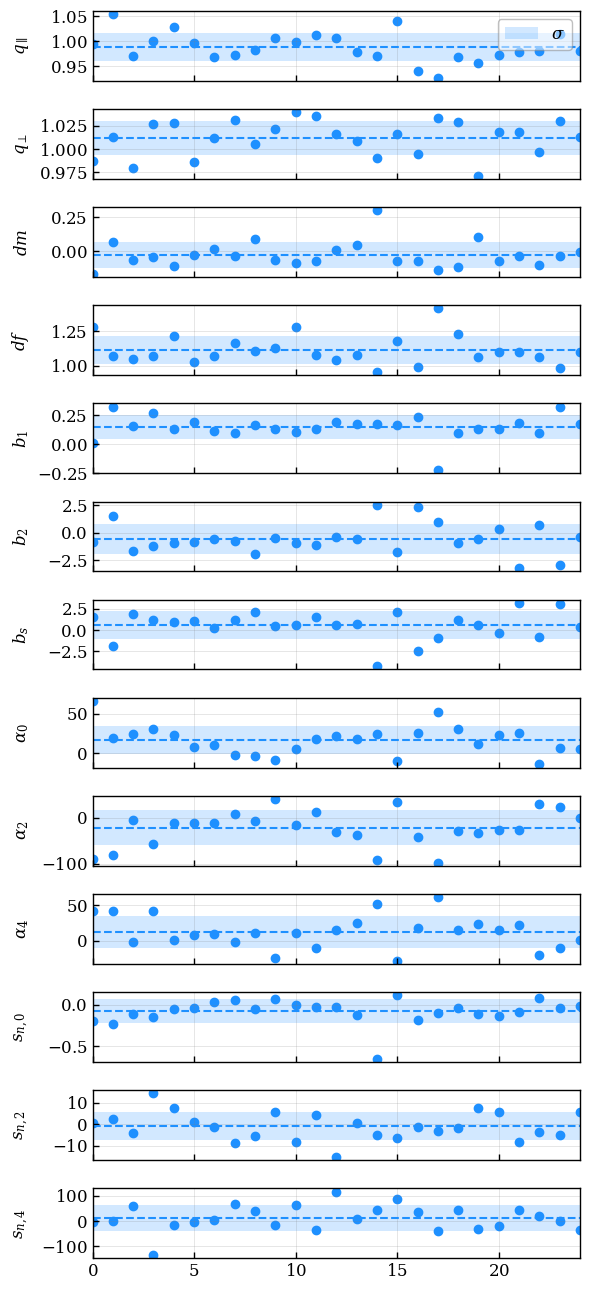

In [28]:
fig, lax = plt.subplots(nrows, 1, figsize=figsize, sharex=True)

desi_y1_err_list = []

for iparam, param in enumerate(params):
    bestfit_vals_rp_cut = np.array([chain.mean(param) for chain in chains_rp_cut])
    bestfit_mean = np.mean(bestfit_vals_rp_cut)
    bestfit_std = np.std(bestfit_vals_rp_cut)
    x = np.arange(len(bestfit_vals_rp_cut))
    ax = lax[iparam]
    ax.axhline(bestfit_mean, ls='--', color='dodgerblue')
    ax.fill_between(x, bestfit_mean - bestfit_std, bestfit_mean + bestfit_std, facecolor='dodgerblue', alpha=0.2, label=r'$\sigma$')
    ax.scatter(x, bestfit_vals_rp_cut)
    ax.set_ylabel(chains[0].params()[param].latex(inline=True))
    # DESI Y1 error
    desi_y1_err = chain_rp_cut.std(param)
    desi_y1_err_list.append(desi_y1_err[0])
    #ax.fill_between(x, bestfit_mean - desi_y1_err/5., bestfit_mean + desi_y1_err/5., facecolor='grey', alpha=0.2, label=r'$\sigma_{Y1}/5$')
    ax.set_xlim(0, np.max(x))
    
lax[0].legend(ncol=2)
fig = plt.gcf()
fig.align_ylabels()
plt.savefig(os.path.join(plots_dir, 'bestfit_rp_cut_mean_dispersion_25mocks_{}_importance_marginalized.png'.format(stat)), dpi=200)
plt.show()

In [17]:
chain_mock0 = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), '{}{}_velocileptors_{:d}_marginalized_astar_mock0.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', i))).remove_burnin(0.5)[::10] for i in range(8)])
chain_mock0_rpcut = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), '{}{}_velocileptors_th{:.1f}_{}_marginalized_astar_mock0.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', rp_cut, i))).remove_burnin(0.5)[::10] for i in range(8)])
chain_mock20 = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), '{}{}_velocileptors_{:d}_marginalized_astar_mock20.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', i))).remove_burnin(0.5)[::10] for i in range(8)])
chain_mock20_rpcut = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), '{}{}_velocileptors_th{:.1f}_{}_marginalized_astar_mock20.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', rp_cut, i))).remove_burnin(0.5)[::10] for i in range(8)])
#chain_mock0_importance = Chain.load(os.path.join(chains_dir.format('complete_'), '{}_mock0_importance{}_velocileptors{}_th{:.1f}{}.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', '_fc' if stat=='corr' else '', rp_cut, '_directedges_max5000' if stat=='power' else '')))

In [18]:
from getdist import plots
g = plots.get_single_plotter(width_inch=10, scaling=False, ratio=1)
g.settings.axes_fontsize = 12
g.settings.axes_labelsize = 12

In [100]:
chain_list = [[Chain.load(os.path.join(chains_dir.format('complete_'), '{}{}_velocileptors_mock{}_{}.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', imock, i))).remove_burnin(0.)[:100:10] for i in range(8)] for imock in range(25)]

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/global/cfs/cdirs/desi/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


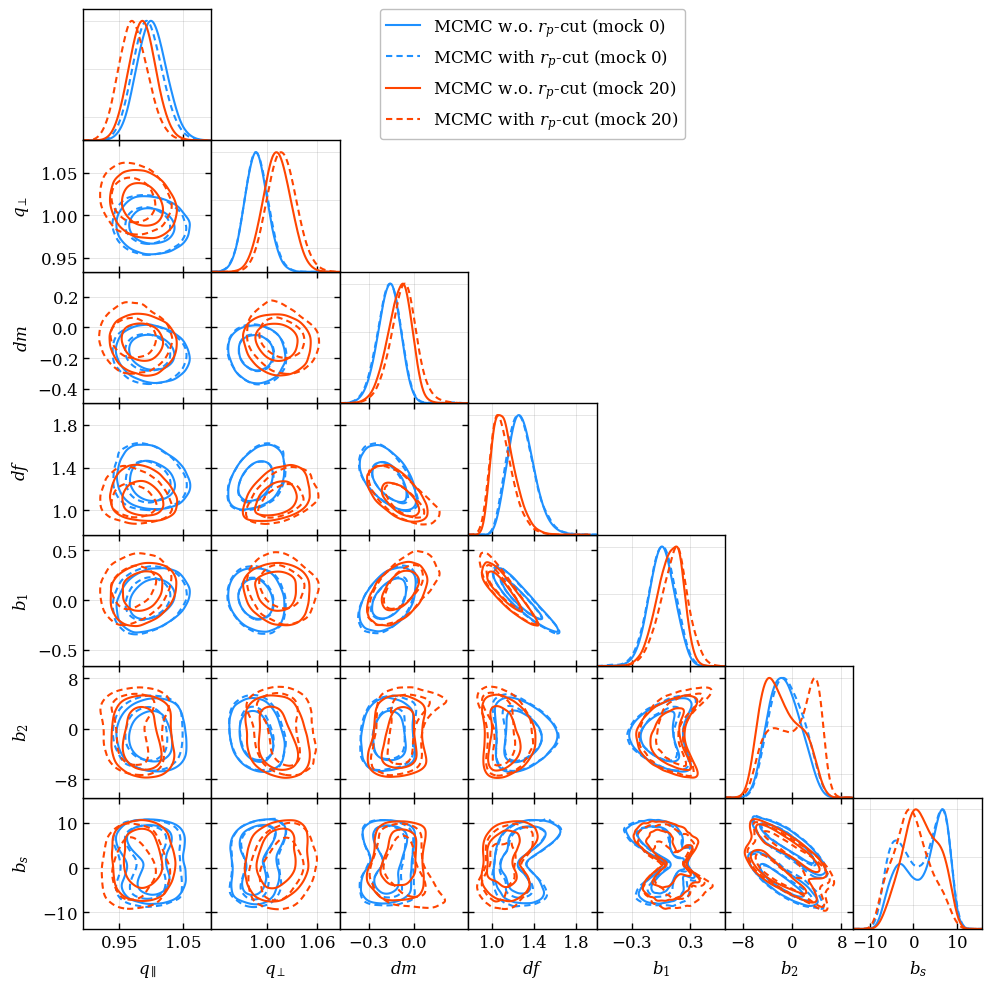

In [23]:
plotting.plot_triangle([chain_mock0, chain_mock0_rpcut, chain_mock20, chain_mock20_rpcut],
                       labels=[r'MCMC w.o. $r_{p}$-cut (mock 0)', r'MCMC with $r_{p}$-cut (mock 0)', r'MCMC w.o. $r_{p}$-cut (mock 20)', r'MCMC with $r_{p}$-cut (mock 20)'],
                       contour_colors=['dodgerblue', 'dodgerblue', 'orangered', 'orangered'],
                       contour_ls=['-', '--', '-', '--'],
                       params=['qpar', 'qper', 'df', 'dm', 'b1', 'b2', 'bs'],
                       g=g, lws=1.5, contour_lws=1.5, filled=False,
                       show=False)
fig = plt.gcf()
fig.align_ylabels()
plt.show()

In [20]:
chain_list = [[Chain.load(os.path.join(chains_dir.format('complete_'), '{}{}_velocileptors_{}_marginalized_astar_mock{}.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', i, imock))).remove_burnin(0.5)[::10] for i in range(8)] for imock in range(25)]

0


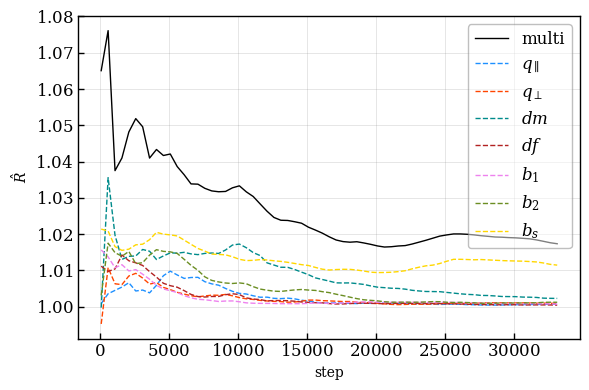

1


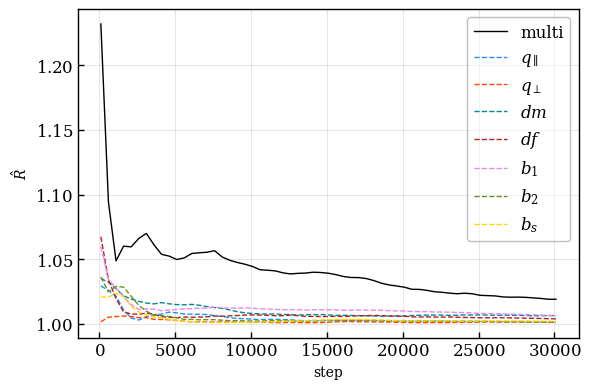

2


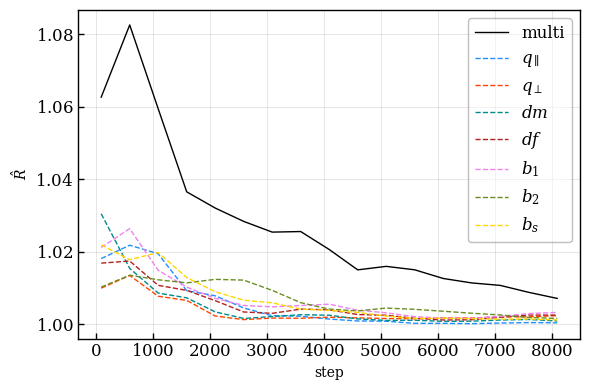

3


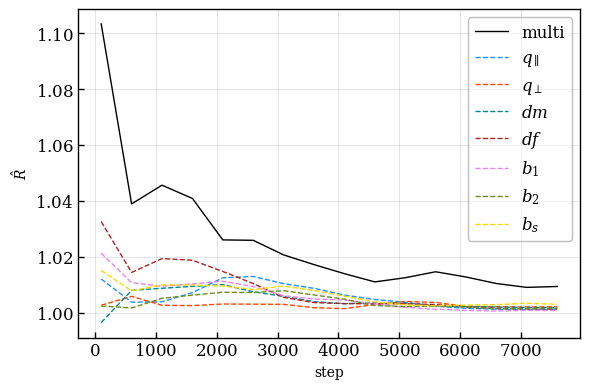

4


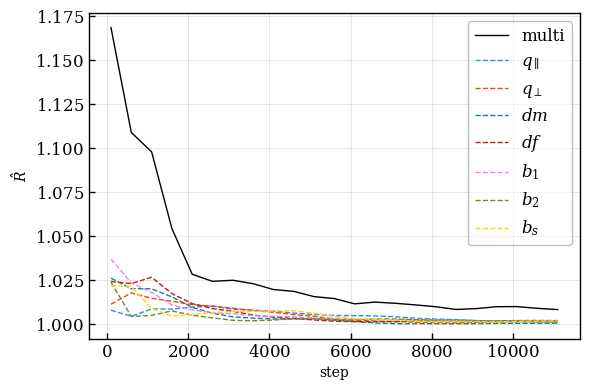

5


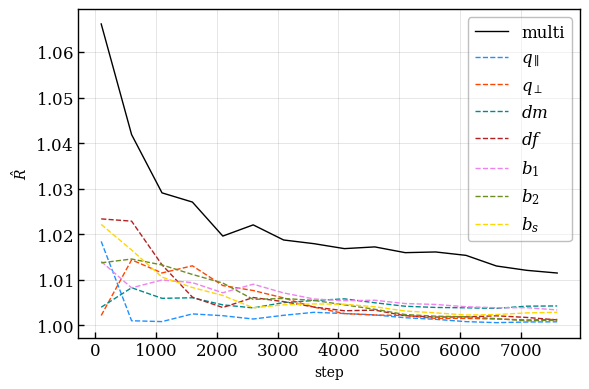

6


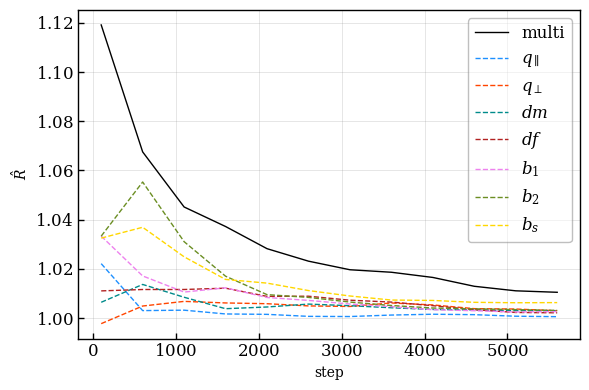

7


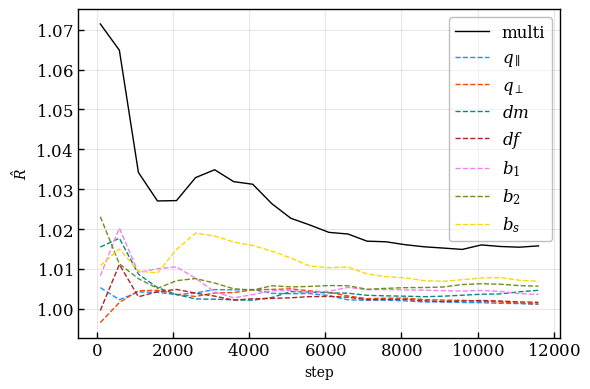

8


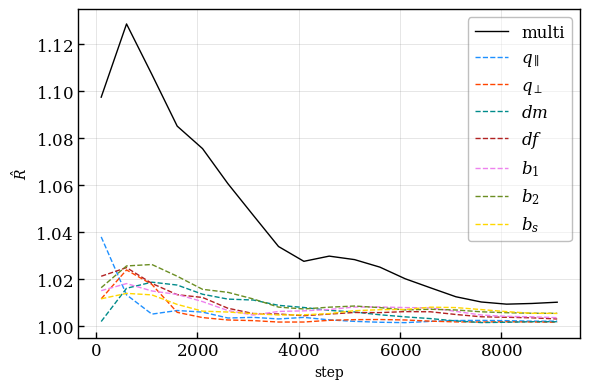

9


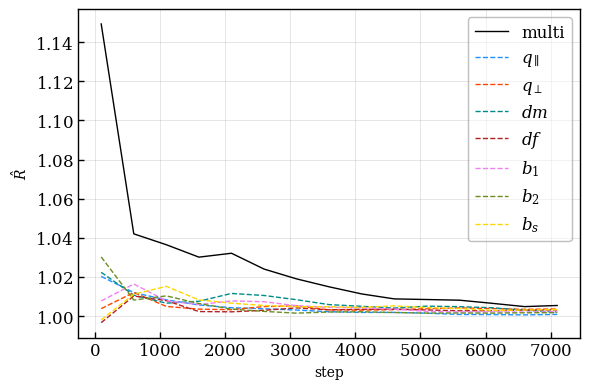

10


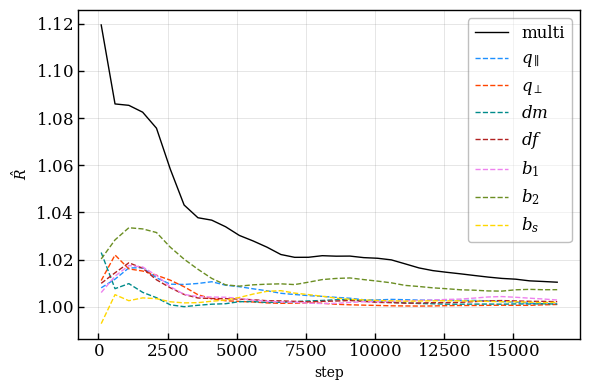

11


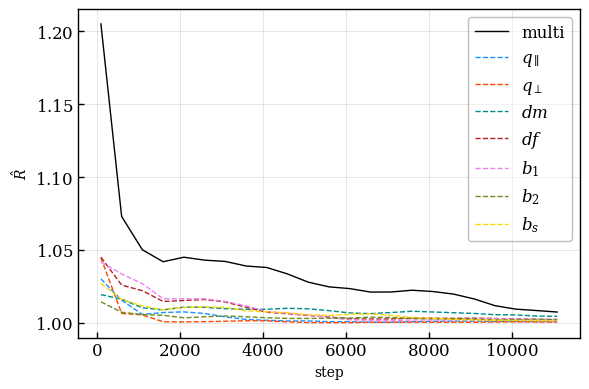

12


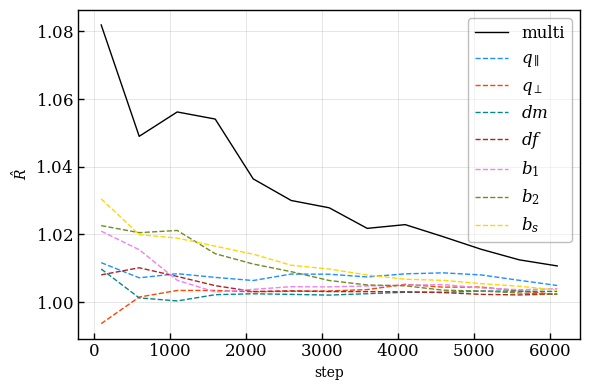

13


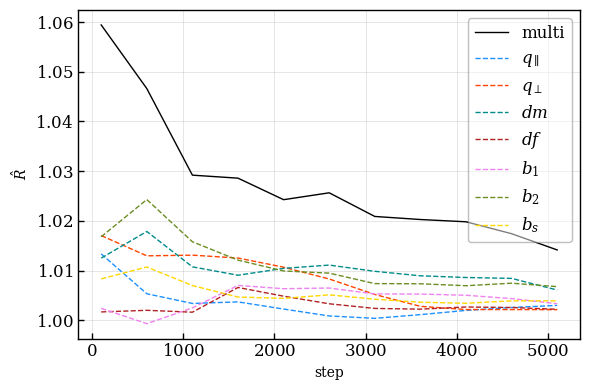

14


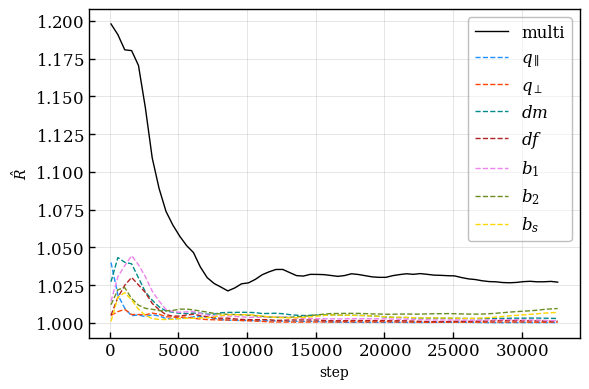

15


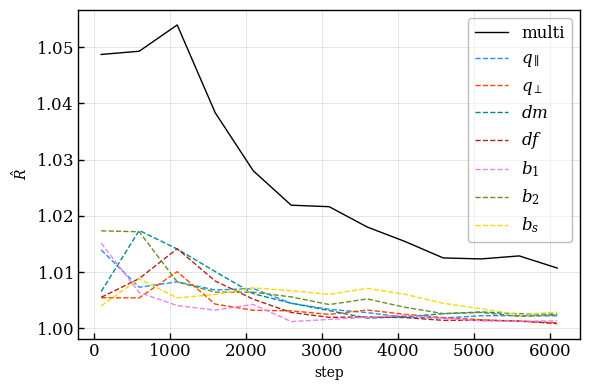

16


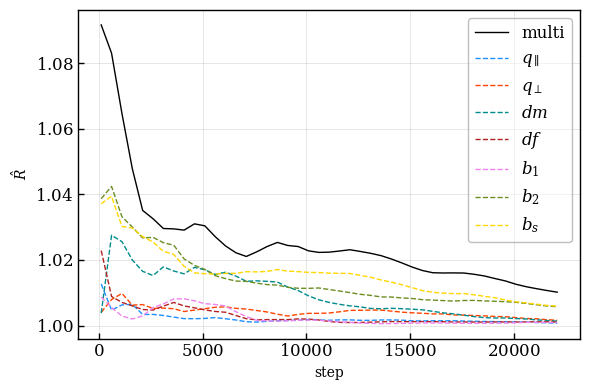

17


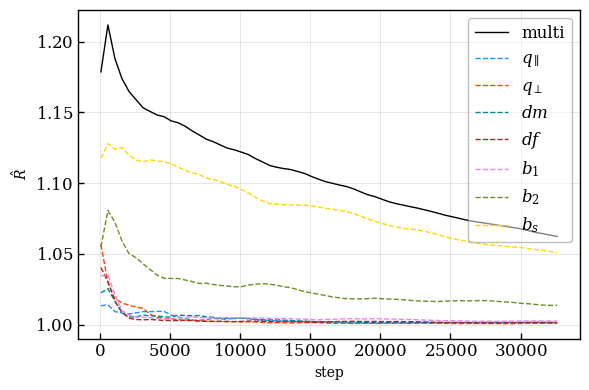

18


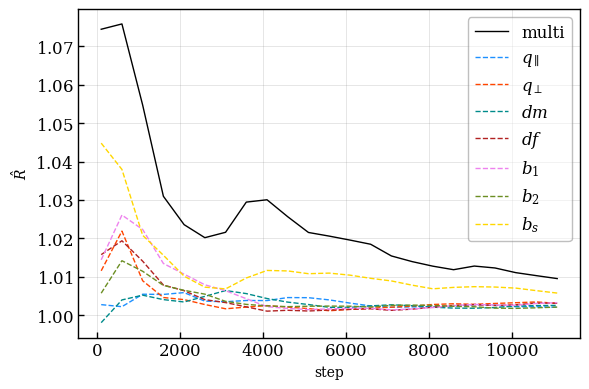

19


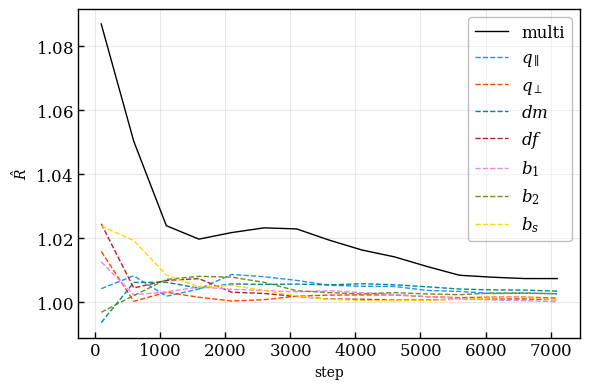

20


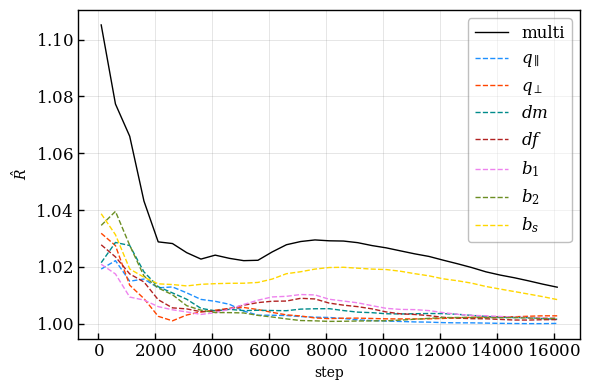

21


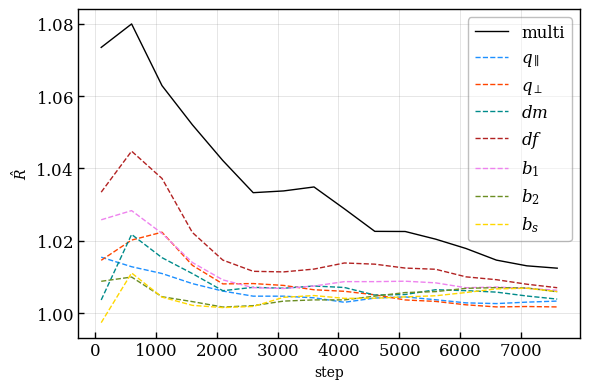

22


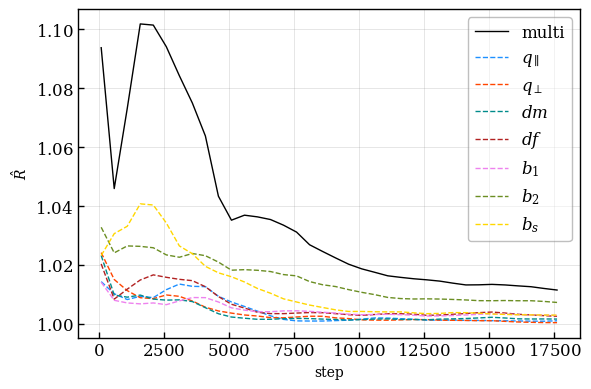

23


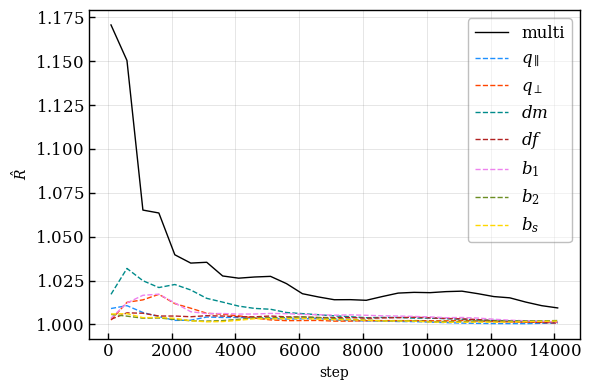

24


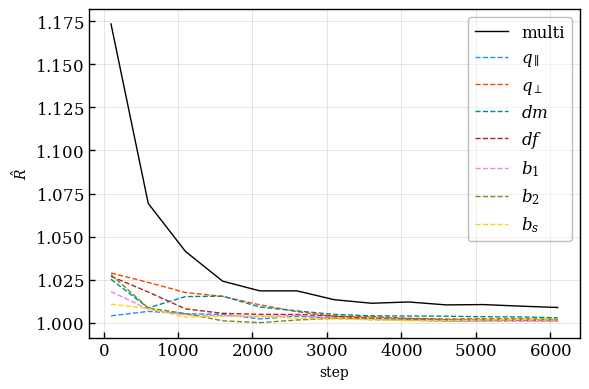

In [21]:
from desilike.samples import plotting

for imock in range(25):
    print(imock)
    plotting.plot_gelman_rubin(chain_list[imock], multivariate=True)
    plt.show()